## Analysis of stock prices using PCA / Notebook 2

In this notebook you will read the file `SP500.csv` that you prepared in notebook 1 into a `Spark` dataframe and then use the code in `lib/spark_PCA.py` to perform PCA on the diff sequences.

We start by starting a spark Context and reading the file into a dataframe.

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov


Populating the interactive namespace from numpy and matplotlib


In [2]:
# read the file in a dataframe.
df=sqlContext.read.csv('SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_D' in c]

Extract the tickers from the column names of `df`

In [4]:

# Add code to extract tickers here
tickers=[c[:-2] for c in col]

tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG'], 476)

#### Create an RDD of numpy arrays
In order to use `spark_PCA.py` we need to transform the dataframe into an RDD of numpy vectors.

Write a function `make_array(row)` that takes as input a row of `df` and returns a numpy array (`dtype=np.float64`) that contains the values of the diff rolumns (`_D`). Use `np.nan_to_num` to transform `nan`s into zeros.

Use `map` to create an RDD called `Rows` of numpy arrays.


In [5]:
def make_array(row):
    # Complete function as described above
    arr = np.zeros(len(tickers))
    trans = row.asDict()
    idx = 0
    
    for ticker in tickers:
        val = trans[ticker+'_D']
        if val and not np.isnan(val):
            arr[idx] = val
        idx+=1            
    return arr
    
###-----FILL-IN using make_array-----    
Rows= df.rdd.map(lambda x:make_array(x))
Rows.first()[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00830103,  0.        ,  0.        ,  0.        ,  0.        ])

In [6]:
# We are now ready to run ComputeCov to create the covariance matrix.
OUT=computeCov(Rows)
OUT.keys()

shape of E= (476,) shape of NE= (476,)


['E', 'Cov', 'NO', 'NE', 'O', 'Var', 'Mean']

In [7]:
from numpy import linalg as LA
eigval,eigvec=LA.eigh(OUT['Cov'])
eigval=eigval[-1::-1] # reverse order
eigvec=eigvec[:,-1::-1]

### Compute percentage-of-variance explained graph
Write code to plot the percentage of variance explained as a function of the number of top eigen-vectors used.

You should get a figure similar to this:

![percent-var-explained](figs/percentageOfVarianceExplained.png)

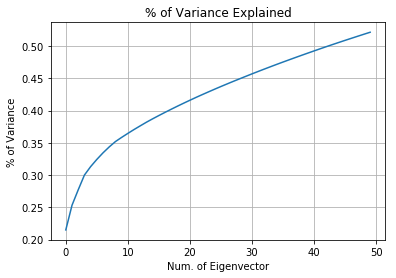

In [8]:
# Add code to plot here
def plot_var_explained():
    k=50
    plot((list(cumsum(eigval[:k])))/sum(eigval))
    title('% of Variance Explained')
    ylabel('% of Variance')
    xlabel('Num. of Eigenvector')
    grid()
plot_var_explained()

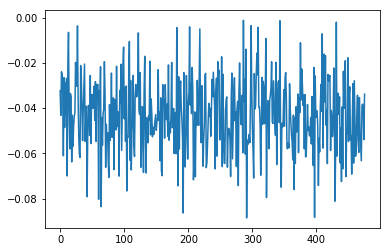

In [9]:
plot(eigvec[:,0])

### Checking your calculations
One good way to check your calculations is to create a scatter-plot projecting the data on two of the largest variance eigen-vectors.

In the directory `figs` you will find scatter plots corresponding to the six combinations of the top 4 eigenvectors.

In these scatter-plots the ticker is replaced by the sector ID.

Stocks from the same sector tend to have similar fluctuations. That is because they have similar sensitivities to costs (labor cost, energy) and profits (income distribution, holiday shopping). For example check out `figs/scatter.2.1.pdf` in which regions that are dominated by Finance, Energy or IT have been marked. 

It is not a requirement, but if you want to reassure yourself that you have done things right, we recommend that you create similar scatter plots and compare with those given. Your scatter-plots will be slightly different, because of the stocks you have eliminated, but spectral analysis is pretty robust, so your scatter plots should be quite similar (remember that the inverse of an eigen-vector is also an eigen-vector, so horizontal or vertical reflections of the scatter plot are meaningless).

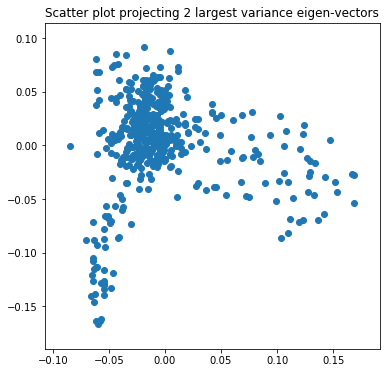

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(eigvec.T[1], eigvec.T[2])
plt.title('Scatter plot projecting 2 largest variance eigen-vectors')
plt.show()

### Performing K-NN on sectors.
We can use spectral analysis to perform dimensionality reduction.

We will use dimensionality reduction in the context of K-NN classification.

Suppose that you the daily change sequence of a an unknown stock, and you want to know to which sector this stock belongs.

We will do this in two steps:
1. Project the daily change sequences of all stocks on the top $d$ eigenvectors to get a vector in $R^d$.
2. Find the $k$ closest neighbors to the unknown stock, and find the plurality label (the plurality label is the one that appears the largest number of times amond the $k$ neighbors. As there are more than 2 labels, it is possible that the plurality label is not the majority.)

In [11]:
import pickle
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
tickers=D['Tickers']
TickerInfo.head()

# list all companies in the Energy sector
TickerInfo[TickerInfo['SECTOR_ID']=='EN']

,Ticker,Name,Sector,SECTOR_ID
41,APC,Anadarko Petroleum|Anadarko Petroleum Corp,Energy,EN
45,APA,Apache Corporation,Energy,EN
60,BHI,Baker Hughes Inc,Energy,EN
83,COG,Cabot Oil & Gas,Energy,EN
101,CHK,Chesapeake Energy,Energy,EN
102,CVX,Chevron Corp.,Energy,EN
107,XEC,Cimarex Energy,Energy,EN
124,CXO,Concho Resources,Energy,EN
125,COP,ConocoPhillips,Energy,EN
145,DVN,Devon Energy,Energy,EN


Write a function called `calc_sectors(tickers)` which takes as input a list of tickers and returns a list of the same length where each ticker is replaced by the corresponding `SECTOR_ID` if the ticker exists in the table `TickerInfo`. Otherwise, the sector is set equal to the ticker. 

In [12]:
#Exclude the following stocks from the dataset
exclude = ['GOOG', 'STT', 'SEE', 'CI', 'EFX']
tickers = [x for x in tickers if x not in exclude]

def calc_sectors(tickers):
    # Your code here
    sectors = []
    
    for i in range(len(tickers)):
        tab = TickerInfo[TickerInfo['Ticker']==tickers[i]]
        if len(tab)==1:
            sectors.append(tab['SECTOR_ID'].values[0])
        else:
            sectors.append(tickers[i])
    
    return sectors
sectors = calc_sectors(tickers)

In [13]:
# Create a dictionary that maps each ticker to the corresponding basis vector
Tick_rep={}
for i in range(len(tickers)):
    Tick_rep[tickers[i]]=eigvec[i,:]

In [14]:
len(sectors)

476

Write a function called `find_closest` which takes as input a query ticker, d and k. and returns a sorted list of tickers, their sectors, and their distance from the query ticker.

For example:
```python 
find_closest('HAL') 
```
should return 

```
[('HAL', 'EN', 0.0),
 ('SLB', 'EN', 0.0054474558470919412),
 ('APA', 'EN', 0.0095375619627422019),
 ('HP', 'EN', 0.0095667138343728166),
 ('BHI', 'EN', 0.01280991458941858),
 ('RDC', 'RDC', 0.012865326588403255),
 ('NBL', 'EN', 0.01654306862676054),
 ('APC', 'EN', 0.019824473381124783),
 ('COP', 'EN', 0.020783142716246431),
 ('ETR', 'UTIL', 0.021988972018102161),
 ('DO', 'DO', 0.022236500402408065)]
```

The distances you get are likely to be somewhat different because of the stocks you eliminated. 
But the majority of the neighbors should be in the energy category.

Similarly you should get results similar to the following for bank of america:
```python
find_closest('BAC')
```

```
[('BAC', 'FIN', 0.0),
 ('STI', 'FIN', 0.0024363061812645009),
 ('FITB', 'FIN', 0.0028848935859552022),
 ('HBAN', 'FIN', 0.0038872420319257242),
 ('RF', 'FIN', 0.0041060232900239878),
 ('EFX', 'INDS', 0.0041804481468865626),
 ('KEY', 'FIN', 0.0046723049368594853),
 ('WFC', 'FIN', 0.0050224290986012853),
 ('AIG', 'FIN', 0.0057982588328606656),
 ('ZION', 'FIN', 0.0060163395623237673)]
 ```
 
 Only tests below.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

d=20
k=5
T='HAL'
def find_closest(T,d=10,k=10):
    nbclf = KNeighborsClassifier(k, metric='euclidean') 
    nbclf.fit([eigs[0:d] for eigs in Tick_rep.values()], Tick_rep.keys())
    dist, ind = nbclf.kneighbors(Tick_rep[T][:d], k)

    gg = 0
    for i in ind[0]: 
        stockID = Tick_rep.keys()[i]
        idx = tickers.index(stockID)
        print(tickers[idx], sectors[idx], (dist[0][gg])**2) #squared Euclidean distance
        gg += 1
        
find_closest('BAC')

('BAC', 'FIN', 0.0)
('STI', 'FIN', 0.0023948019302105494)
('FITB', 'FIN', 0.0029704249609305011)
('HBAN', 'FIN', 0.0039887411959824886)
('PRU', 'FIN', 0.0041482168168673764)
('S', 'S', 0.004177456510363671)
('ITW', 'INDS', 0.0045941908094950029)
('WFC', 'FIN', 0.0050601871121382066)
('TXT', 'INDS', 0.0058613713232476897)
('ZION', 'FIN', 0.0059301278334474511)


/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Here are few stocks that have most neighbours in the same sector

```
Ticker     Sector
BAC         FIN
BAX         HC
EQR         RE
HOG         CD
HCP         RE
HAL         EN
SYK         HC
```

# Please do not modify or delete the following cells. They are required for the autograder. If deleted your final might not be graded. 

In [ ]:
import Tester
Tester.test0(tickers)

In [ ]:
import Tester
Tester.test1(eigval,eigvec)

In [ ]:
import Tester
Tester.test2(eigval,eigvec)

In [ ]:
import Tester
Tester.test3(eigval,eigvec)

In [ ]:
import Tester
Tester.test4(eigval,eigvec)

In [ ]:
import Tester
Tester.test5(find_closest)

In [ ]:
import Tester
Tester.test6(find_closest)

In [ ]:
import Tester
Tester.test7(find_closest)

In [ ]:
import Tester
Tester.test8(find_closest)

In [ ]:
import Tester
Tester.test9(find_closest)

In [ ]:
import Tester
Tester.test10(find_closest)

In [ ]:
import Tester
Tester.test11(find_closest)

In [ ]:
import Tester
Tester.test12(find_closest)

In [ ]:
import Tester
Tester.test13(find_closest)

In [ ]:
import Tester
Tester.test14(find_closest)